In [73]:
from __future__ import print_function
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti

mpl.style.use('ggplot')
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score, precision_score, \
                            recall_score, accuracy_score, recall_score, \
                            roc_curve, auc, roc_auc_score, precision_recall_curve

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import config

from collections import Counter, OrderedDict, defaultdict
import operator
import time
from pprint import pprint as pp

%matplotlib inline
np.random.seed(42)
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

In [74]:
# Load training data into memory
df = pd.read_csv('nifty_train_data.csv')
df.head()

,ATR,NATR,TRANGE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,Returns_30day
0,120.130816,1.378983,133.30,0.529872,0.983280,8580.540000,-87.806054,8919.874286,-26.102637,66.095791,8554.437363,4368.6536,8680.0750,8665.900,8681.116667,8688.7250,0.0
1,119.446472,1.356498,110.55,0.865844,0.983668,8606.957143,-87.362442,8889.157143,-21.707692,100.859579,8585.249451,10172.6546,8774.6875,8775.875,8785.750000,8790.6875,-0.0
2,116.393152,1.321246,76.70,-0.181358,0.983568,8645.924286,-86.082075,8835.740000,-14.601209,96.430030,8631.323077,9298.7506,8826.0625,8831.750,8824.283333,8820.5500,0.0
3,114.179356,1.287384,85.40,-0.120294,0.983830,8703.688571,-79.150506,8771.518571,-5.217692,85.127860,8698.470879,7246.7526,8845.9625,8851.600,8857.433333,8860.3500,0.0
4,114.523687,1.287463,119.00,1.158947,0.986987,8774.917143,81.074704,8692.140000,6.367473,63.480780,8781.284615,4029.8094,8871.5625,8853.950,8867.733333,8874.6250,0.0


In [75]:
# Capture 30 return data into y 
y = df['Returns_30day']
Counter(y)

# Drop 30 day return column
# We know this data already based on around 30 day return
# We ll use this data to predict 30 day return.
df.drop(['Returns_30day'], axis=1, inplace=True)


In [76]:
# Capture dataframe values in x
X = df.values
# table dimensions
X.shape

(1206, 16)

In [77]:
# table dimensions
y.shape

(1206,)

In [78]:
# Train data on 80% and test of rest 20%
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
#from tpot.builtins import StackingEstimator

# Create big array
x1 = X[:80000]
y1 = y[:80000]
# Creating training and testing data
training_features, testing_features, training_target, testing_target = train_test_split(x1, y1, 
                                                                                        train_size=0.80, 
                                                                                        test_size=0.20,
                                                                                        stratify=y1,
                                                                                        random_state=42)
# Over-sampling training data
X_resampled, y_resampled = SMOTE().fit_sample(training_features, training_target)

normalizer = StandardScaler()
X_resampled = normalizer.fit_transform(X_resampled)
testing_features = normalizer.transform(testing_features)

# Training Model
exported_pipeline = RandomForestClassifier(bootstrap=False, max_features='auto', 
                                           min_samples_leaf=1, min_samples_split=5, 
                                           n_estimators=80, 
                                           criterion='gini',
                                           n_jobs=-1)

exported_pipeline.fit(X_resampled, y_resampled)
y_pred = exported_pipeline.predict(testing_features)

print(time.ctime())

print('Training test accuracy:', accuracy_score(testing_target, y_pred))

Sun May 24 13:58:30 2020
Training test accuracy: 0.4132231404958678


In [79]:
# validate data test
validation_testing_features = normalizer.transform(X[:80000])
validation_y_actual = y[:80000]
validation_y_pred = exported_pipeline.predict(validation_testing_features)
print('Validation test accuracy:', accuracy_score(validation_y_actual, validation_y_pred))

Validation test accuracy: 0.8822553897180763


In [80]:
# Print pipeline used in RandomForest
exported_pipeline

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [81]:
# Print indicator importance value

def full_form(x):
    try:
        return config.tickers[x]
    except:
        return x

importance = exported_pipeline.feature_importances_
feature_set = {
    'Feature_name': df.columns,
    'Importance': importance
}

f = pd.DataFrame(feature_set).sort_values(['Importance'], ascending=False)
f['full_name'] = f.Feature_name.apply(full_form)
f['Importance'] = f['Importance'].apply(lambda x: np.round(x,4)) 
bad_features = f[f.Importance < 0.01].Feature_name
print('Low importance features:', bad_features.values)
f.to_csv('feature_importance.csv')
f



Low importance features: []


,Feature_name,Importance,full_name
8,LINEARREG_SLOPE,0.1254,LINEARREG_SLOPE
6,LINEARREG_ANGLE,0.1193,LINEARREG_ANGLE
1,NATR,0.0737,Normalized Average True Range
9,STDDEV,0.0732,STDDEV
11,VAR,0.0688,VAR
4,CORREL,0.0628,CORREL
3,BETA,0.0605,BETA
2,TRANGE,0.0572,True Range
0,ATR,0.0552,Average True Range
7,LINEARREG_INTERCEPT,0.0508,LINEARREG_INTERCEPT


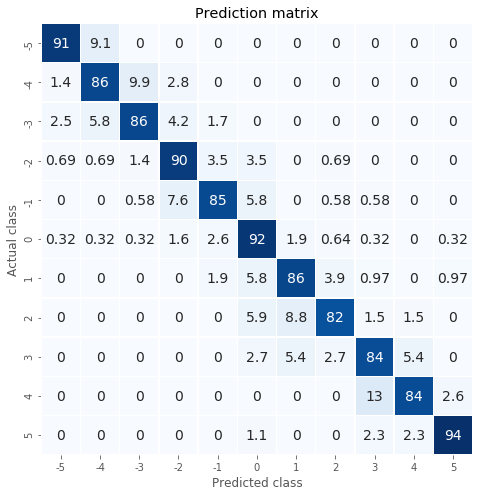

In [82]:
# Print confusion plot

def confusion_plot(y_test, y_predicted, classes):
    cm = confusion_matrix(y_test, y_predicted)

    # Scaling values
    cm = cm.astype('float')*100 / cm.sum(axis=1)[:, np.newaxis] 
    np.set_printoptions(suppress=True)
    mpl.rc("figure", figsize=(7,7)) #subplot size

    hm = sns.heatmap(cm, 
                cbar=False,
                annot=True, 
                square=True,
                yticklabels=classes,
                xticklabels=classes,
                cmap='Blues',
                linewidths =.5,
                annot_kws={'size':14} #text size
                )
    plt.title('Prediction matrix')
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=100)
    plt.show()

confusion_plot(validation_y_actual, validation_y_pred,[-5,-4,-3,-2,-1,0,1,2,3,4,5])


In [83]:
# populate predicated and probability values
predicted = np.argmax(exported_pipeline.predict_proba(validation_testing_features), axis=1) - 5
prob = np.max(exported_pipeline.predict_proba(validation_testing_features), axis=1)

In [84]:
# Check how predication faired with actual returns
cutoff_prob = 0.4
cutoff_returns = 2

def _color_red_or_green(val):
    color = 'red' if val < 0.5 else 'green'
    return 'color: %s' % color

df_result = pd.DataFrame({
    'predicted': validation_y_pred,
    'actual_returns': validation_y_actual,
    'prob': prob
})


df_result_final = df_result[(np.absolute(df_result.predicted)>=cutoff_returns) 
                            & (df_result.prob>=cutoff_prob) 
#                             &(df_result.predicted==df_result.true_label)
                           ]
print(len(df_result_final)/len(df_result))
df_result_final.style.applymap(_color_red_or_green, subset=['prob'])
#df_result_final.head()

0.4975124378109453


,predicted,actual_returns,prob
11,-2.000000,-2.000000,0.881250
12,-4.000000,-4.000000,0.968750
13,-4.000000,-4.000000,0.670833
25,3.000000,3.000000,0.947917
26,4.000000,4.000000,1.000000
27,4.000000,4.000000,0.995833
28,5.000000,5.000000,0.782292
29,5.000000,5.000000,0.798958
30,5.000000,5.000000,0.893750
31,3.000000,3.000000,0.950000


In [85]:
# lets trade using this data
trade_amount = 1000
#transaction_charge = 0.25/100*2
#crypto_slippage = 0.97**2
#currency_slippage = 0.995**2

def returns(pred, true_):
    if pred>=2: 
        if true_>=pred:
            return pred
        else:
            return true_
    if pred<=-2:
        if true_<=pred:
            return -pred
        else:
            return -true_

df_result_final['Action'] = df_result_final['predicted'].apply(lambda x: 'Long' if x>0 else 'Short')
df_result_final['realised_returns'] = df_result_final.apply(lambda row: returns(row['predicted'], row['actual_returns']), axis=1)
df_result_final['profit'] = df_result_final.apply(lambda row: row['prob']*row['realised_returns']*np.sqrt(np.absolute(row['predicted'])/2)*0.01*trade_amount, axis=1)
print('Net profit:', df_result_final['profit'].sum())
# Display top 10 trades
df_result_final.head(n=10)


Net profit: 22875.172854609496


,predicted,actual_returns,prob,Action,realised_returns,profit
11,-2.0,-2.0,0.881250,Short,2.0,17.625000
12,-4.0,-4.0,0.968750,Short,4.0,54.800776
13,-4.0,-4.0,0.670833,Short,4.0,37.948064
25,3.0,3.0,0.947917,Long,3.0,34.828682
26,4.0,4.0,1.000000,Long,4.0,56.568542
27,4.0,4.0,0.995833,Long,4.0,56.332840
28,5.0,5.0,0.782292,Long,5.0,61.845587
29,5.0,5.0,0.798958,Long,5.0,63.163202
30,5.0,5.0,0.893750,Long,5.0,70.657141
31,3.0,3.0,0.950000,Long,3.0,34.905229


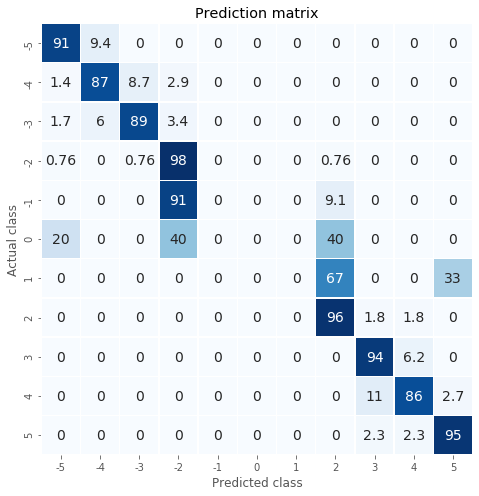

In [86]:
# lets plot actual and predicated returns on a chart
confusion_plot(df_result_final.actual_returns, df_result_final.predicted, [-5,-4,-3,-2,-1,0,1,2,3,4,5])

In [87]:
# What went wrong
print('Wrong predictions')
df_result_final[df_result_final.actual_returns!=df_result_final.predicted].head(n=30)

Wrong predictions


,predicted,actual_returns,prob,Action,realised_returns,profit
70,-2.0,-3.0,0.641667,Short,2.0,12.833333
78,3.0,4.0,0.554167,Long,3.0,20.361383
80,4.0,5.0,0.821875,Long,4.0,46.492271
81,4.0,5.0,0.644792,Long,4.0,36.474925
91,-4.0,-3.0,0.723958,Short,3.0,30.714951
107,-2.0,-3.0,0.436458,Short,2.0,8.729167
145,3.0,5.0,0.446875,Long,3.0,16.419236
146,3.0,5.0,0.515625,Long,3.0,18.945272
157,-3.0,-4.0,0.446875,Short,3.0,16.419236
173,-4.0,-3.0,0.671875,Short,3.0,28.505242


In [88]:
# How did we lose
print('Lost money')
df_result_final[df_result_final.realised_returns<0].head(n=30)

Lost money


,predicted,actual_returns,prob,Action,realised_returns,profit
961,2.0,-2.0,0.469792,Long,-2.0,-9.395833
1053,2.0,-1.0,0.511458,Long,-1.0,-5.114583


In [89]:
# How much did we make
print('Net profit:', df_result_final['profit'].sum())

Net profit: 22875.172854609496


In [90]:
# How long did we trade
print('Number of days', validation_y_pred.shape[0]/96/4)

Number of days 3.140625
